# Makemore part 3

## The main goals in this lecture it seems
Is to basically improve the NN we've already made by tweaking things (mainly parameters) so we get better losses in the same amount of time. We fix the softmax, tanh saturation, .... All to get better losses  heheh.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [2]:
# read in all the words
words = open('../2 - makemore/names.txt', 'r').read().splitlines()
words[:8]
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # 0.2# tanh part; make hpreact closer to 0
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # tanh bit
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for initial loss

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [7]:
# same optimisation as last time
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/  20000: 3.3179
  10000/  20000: 2.1910


In [8]:
h

tensor([[ 0.9471, -0.3682,  0.1597,  ..., -0.9903,  0.9458,  0.9886],
        [-0.5081,  0.6813, -0.9376,  ..., -0.8153,  0.4828,  0.0019],
        [-0.8645, -0.3816, -0.8966,  ..., -0.6087, -0.8634,  0.9365],
        ...,
        [ 0.9963,  0.4989, -0.5916,  ..., -0.9824,  0.9864,  0.6119],
        [-0.8309, -0.9107,  0.3928,  ..., -0.9592, -0.8815,  0.6119],
        [-0.1649,  0.3825,  0.5761,  ...,  0.9952, -0.5787, -0.8901]],
       grad_fn=<TanhBackward0>)

In [9]:
logits.shape # much closer to 0 now -> initial loss is close to equal prob distr. one (~3.3). || On the initial loss

torch.Size([32, 27])

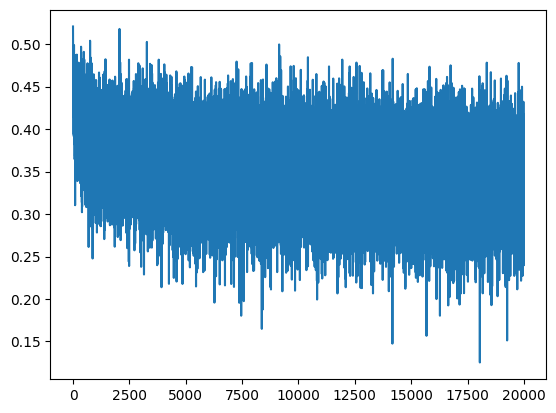

In [10]:
plt.plot(lossi)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking, i.e tells torch we won't need gradients for anything in this tensor -- makes stuff more efficient 
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)

  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1958730220794678
val 2.225281238555908


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1,-1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
aal.
hari.
kemri.
reety.
saland.
emmahnel.
amerynci.
aqui.
ner.
kentchaiiv.
kaleigh.
ham.
jora.
quintos.
line.
kaid.
quinatho.
dearixi.
jace.


First thing -- our initialised parameters are munted. Like, we start at ~28 and go to ~2.8 straight away, and then stay there for a bit.
The "hockey stick" of the graph is simply because your initial was so terrible that there's a massive difference.
Basically, you should always have a rough idea of what your initial loss should be when training NNs.

In our case; we'd want every possibility to be equally likely -- all chars should be the same prob; we have no reason not to believe this initially (i.e each char should have 1/27 prob).
(This is basically last video's exercise so :O )


In [13]:
# So to get the loss:
-torch.tensor(1/27).log() # This would be loss for an equal prob. distribution model
# Example with a 4 tensor thing
def initial_loss_example(tensor_nums = None):
	if tensor_nums == None:
		logits = torch.randn(4) * 100
	else:
		logits = torch.tensor(tensor_nums)
	probs = F.softmax(logits, dim=0 )
	loss = -probs[2].log() # Select random
	print(f'{logits=}, {probs=}, {loss=}')	
initial_loss_example([0.0,0.0,5.0, 0])
## Basically, the logits would initially be random; sometimes you would luck out and get a good probability (high # in the element you want), but way more likely you'd get trash
initial_loss_example([6.0,0.0,-1.0, 4.0])
initial_loss_example()
""" And if your logits are big, your loss is even bigger. Big enough, you'd get infinity!"""
initial_loss_example([60.0,0.0,-1.0, 40.0])
initial_loss_example([60.0,210.0,86.0, 100.0])
"""
So we want logits to be ~0 when network is initialised. Or equal, since the normalisation yknow ;P

This means, well, we don't want to add a bias to the final logits bit so *0, and we'll make the weights REAAAALLLY small (but not *0 or something to do with symmetry/symmetry breaking; apparently it'd be fine in this case but best not to. It's probably something like you effectively make that whole set of weights useless or something???) Okay let's go!
/// 12:00 okay so we fixed it, now our initial loss is way better @ ~3.3, and our graph doesn't look like a hockey stick anymore (no easy gains). Very nice!

=> Also end up getting better test results :D (since we have more time *actually* optimising the NN outputs & loss).
"""



logits=tensor([0., 0., 5., 0.]), probs=tensor([0.0066, 0.0066, 0.9802, 0.0066]), loss=tensor(0.0200)
logits=tensor([ 6.,  0., -1.,  4.]), probs=tensor([8.7817e-01, 2.1768e-03, 8.0079e-04, 1.1885e-01]), loss=tensor(7.1299)
logits=tensor([-44.4038,  29.6392,  15.3608,  19.5366]), probs=tensor([6.9747e-33, 9.9996e-01, 6.2944e-07, 4.0971e-05]), loss=tensor(14.2784)
logits=tensor([60.,  0., -1., 40.]), probs=tensor([1.0000e+00, 8.7565e-27, 3.2213e-27, 2.0612e-09]), loss=tensor(61.)
logits=tensor([ 60., 210.,  86., 100.]), probs=tensor([0., 1., 0., 0.]), loss=tensor(inf)


"\nSo we want logits to be ~0 when network is initialised. Or equal, since the normalisation yknow ;P\n\nThis means, well, we don't want to add a bias to the final logits bit so *0, and we'll make the weights REAAAALLLY small (but not *0 or something to do with symmetry/symmetry breaking; apparently it'd be fine in this case but best not to. It's probably something like you effectively make that whole set of weights useless or something???) Okay let's go!\n/// 12:00 okay so we fixed it, now our initial loss is way better @ ~3.3, and our graph doesn't look like a hockey stick anymore (no easy gains). Very nice!\n\n=> Also end up getting better test results :D (since we have more time *actually* optimising the NN outputs & loss).\n"

### Fixing our saturated tanh ~15:00
Okay, so that's cool. But *there's another* problem lurking in our midst!
notice:

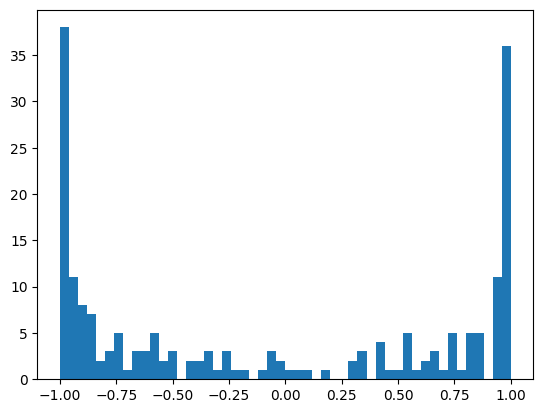

In [14]:
plt.hist(h.view(-1).tolist(),50); # h is (32,200), h.view(-1) -> [(6400)], then convert to a list so plt can read it nicely 

# Hm.... A lot of our values are either at 1, or -1... Let's look at hpreact, which is the tensor that gets tanh'd into h.


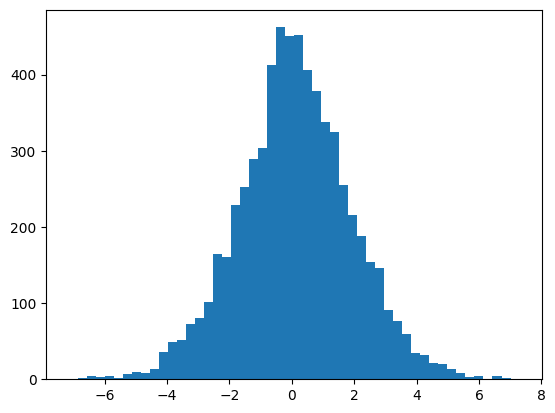

In [15]:
plt.hist(hpreact.view(-1).tolist(),50);

### SHEEEEEEESH that's big values -15 to 15
# well... I reran the notebook so it's fixed now lol but yeah

![image](4-makemore-pt3/Capture.PNG)
The video goes way more indepth about this ~16:00 but basically:

Our loss backpropagates through everything right? Our tanh gradient is (1-t**2) * out.grad, where t is the part where it gets 'squished", t= (e^(2x)-1)/(e^(2x)+1). And think about the graph of a tanh; how it flats out near -1, 1. If you had a t= 0, then your output would just be out.grad -- it lets your loss flow through perfectly! Anything else, and it begins inhibitting your *flows*. Especially near the tails, you'd get an ~0 gradient -- changing your inputs by a bit here would give a negligible change in the output of your tanh! So changing it would have no impact on the loss.

I.e the weights/biases of this  neuron have very little effect on the loss! i.e the gradients basically vanish for this little neuron. This kinda kills it!

I.e due to the tanh derivative here, the gradient flowing through tanh can only ever decrease the further it is from t=0. So if all the h's are close to -1, 1, then the gradients flowing through (backwards) through the network basically gets destroyed at this point because it'll be ~0 gradient; these neurons' weights/biases have no effect on the loss apparently. Dead neuron since it can't change well anymore! too activeeeee 

The concern is if a lot of neurons (from our tanh) output are -1, 1, then our gradients going through the NN get destroyed and it can't learn well anymore.



torch.Size([1, 200])

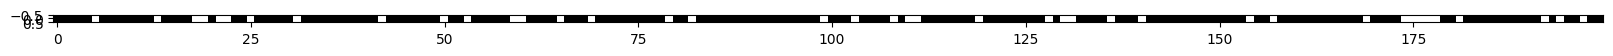

In [16]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # White is 'true', i.e a dead neuron!
h.shape # 200 neurons
# Basically, we'd be in trouble if an entire layer (column wise) was white (i.e dead neurons because those tanh neurons would be very active and in a flat tail --> gradients would get 'destroyed' by being so close to 0 -> wouldn't be able to learn well.).

# I.e: Tanh neuron s.t. no single example ever activates the tanh neuron in the 'active' part of the tanh. I.e if all its examples land in the tail (white) end. So our gradients will flow through and we will learn, will change, blahh.

# But yeah, the video explains this much better.

## Dead neurons can happen if you have a learning rate too high and they kinda "jump" into a dead spot, or it can happen by the random initialisation, just by chance they spawn in a shit spot. See the video!	

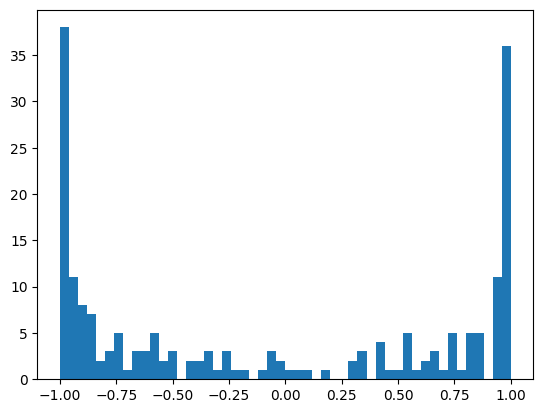

In [17]:
## So basically, the hpreact that goes into tanh is too large, too saturated in both sides of the tanh, so there's less training for the neurons since they update less frequently. After fixing by making W1, b1 smaller:
plt.hist(h.view(-1).tolist(),50);

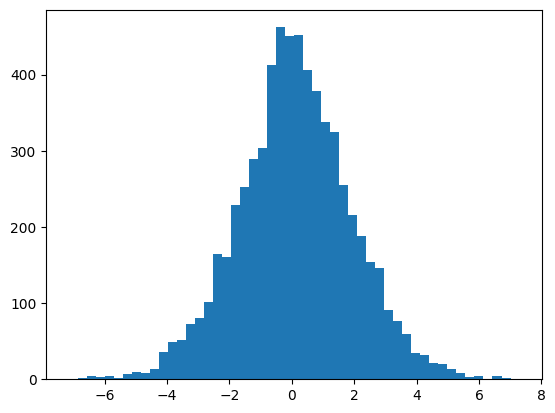

In [18]:
plt.hist(hpreact.view(-1).tolist(),50); # the stuff before it gets tanh'd.

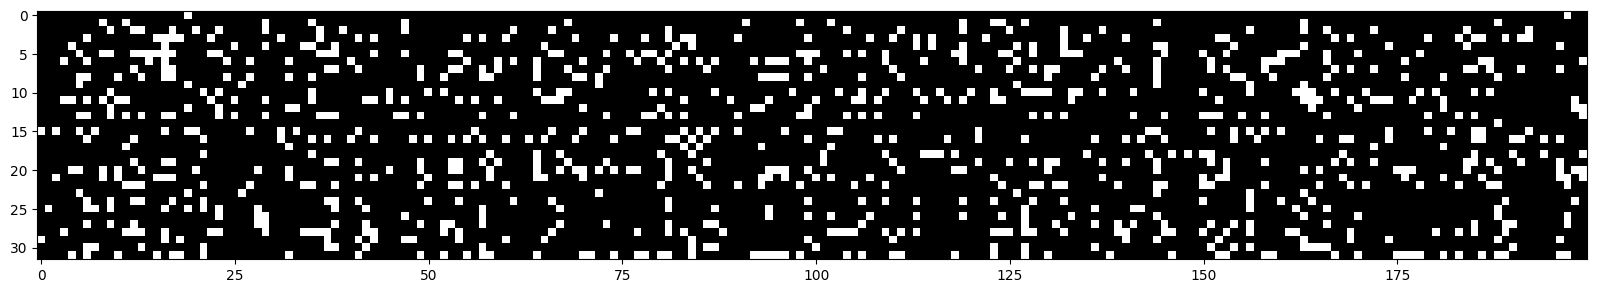

In [24]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
# LMAOO -- because, there's no neurons saturated above 0.99. Okay, let's change * 0.1 to *0.2 for w1 lmao so we get *some*.

# loss log
Tl;dr -- Initialisation and its impact on performance. Just by tweaking a few things, look at our improvements! ~27:00

Since our network is small, we were still able to learn despite this, but the deeper/more complex your network is, it might get to a point where it'll barely/won't learn at all due to these initialisation errors. In general, initialisation and taking care of it is important!

(Obviously, this would be harder to fix by hand for complex stuff -- like... we legit put magic numbers in there, lmaoo. But that's for the next segment to talk about!! We can get shit to do it for us :o)

### original:
train 2.1245384216308594 val 2.168196439743042

### fix softmax confidently wrong:
No hockey stick! Start at a decent probability distribution you scoundrel! So we have more time to optimise instead of spending the first few thousand steps just massively 'squishing' our W2/b2 parameters.
train 2.07 val 2.13

### fix tanh layer too saturated at init:
So we don't have to spend as many cycles squashing down the weight matrix, (we do that in initialisation now :P) to fix our h values etc.. so our neurons can learn better, as they have more time to properly train.


train 2.0355966091156006 val 2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
Similar to above, but the big deal here is we didn't have to introduce any magic numbers!! It's all right there for us to grab, without having to look at histograms, ....

train 2.0376641750335693 val 2.106989622116089

## add batch norm layer
In this case, we don't have a massive improvement because our network is so simple. But batch normalisation is OP because this way, we don't have to perfectly calculate how we should scale our weights for each input, blah blah... We just batch norm! Ofc, this comes at a weird price ~50mins but yeah. Batch norm time!

train 2.0668270587921143 val 2.104844808578491

In [20]:
### Kaiming stuff
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std()) # Close to 0, 1 as expected since randn is from normal /gaussian distribution
print(y.mean(), y.std()) # oh shit! the mfer std changed! We'd like to keep this close to N~ (0,1) for all the stuff basically. 
# He added some graphs to show this but yeah, it's... Yeah.
# Anyways, you fix this by doing 'kaiming' thingy on it. The gain (which is kinda an 'equaliser' if certain functions like tanh, ... contract the thing) changes based on the function.
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # by sqrt(fan in), fan in is just the first bit of the matrix.
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std()) 

tensor(0.0014) tensor(1.0041)
tensor(0.0054) tensor(3.2633)
tensor(-0.0172) tensor(0.9912)
tensor(0.0051) tensor(0.9690)


#### Kaiming time
~28:00
....
Basically.


36:00... Omfg, this guy just.. BRUH. Okay, so in the past, NNs were finnicky and shit and you had to really care about this stuff or else it wouldn't train well, but now it's less important since we have made advances like (which we'll get into future vids)
- residual connections
- ... normalisations (layer norm, batch norm, blah)
- better optimisers like Adam.

In practice, all karpathy does is basically just normalsie the weights by the sqrt of the fan in (i.e default kaiming style).
Anyways, let's go change the initialisation now. Yep. Done that. Coolio.

# A Modern Innovation: Batch Normalisation
~40mins in.
So this basically allows much deeper networks to become normalised, so we don't have to deal with scaling the weights properly initially, as this becomes very complicated on deeper networks.

You basically just... normalise the hidden states hehe so their outputs become nice -- like hpreact: We don't want it to be too small, or else the tanh() will just  not do anything (-1), but we don't want them to be too large because then they'll be too saturated.

Literally batchnorming is: So you want the hidden states (hpreact - oh this stands for h pre activation LOL) to have a gaussian (normal) distribution (to prevent saturated tanh, ...). So uh. Why not just make them gaussian? Lol.
	And you can do this completely fine because standardising/normalising is a perfectly differentiable operation! Look at the code! :P

Big K changed the code way above, but I'm copying it down here first. I'll make another clean makemore I guess @.@

Remember how we normalise (from all dem statistics :o)
(x - u) / o, u = mean, o = std. So we can just do that here @.@

This is the paper that implemented batchnorm https://arxiv.org/abs/1502.03167, and this is basically the pseudocode we're gonna add.
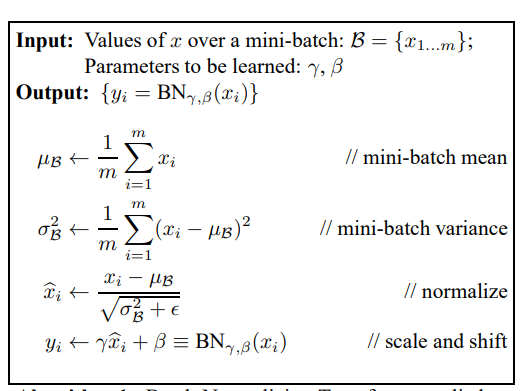

In [78]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # 0.2# tanh part; make hpreact closer to 0
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # tanh bit. Useless now that we have added batchnorm, since we take away the mean, and it cancels b1 out basically. lol bnbias does the job now hehe. It's just a waste of computation, but that's it.
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # initial loss
b2 = torch.randn(vocab_size,                      generator=g) * 0 # for initial loss

# Adding scale/shift for normalisation so our backprop can tell us if the distribution needs to shift to properly learn whatever it is we're trying to do.
# Remember, the point of batchnorm is to normalise hpreact so we don't get saturated tanh INITIALLY, but the actual problem we're solving might *require* some distr that's not N~(0, 1), so this allows us to move the dist as required. Read the bit below too
# At initialisation; our hpreact will be perfectly normal (haha), but during optimisation we can backprop and change this if required so we can scale and shift the distribution
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) 

# For getting the 'end' mean and std of the training set so we can evaluate loss and do sampling woohoo
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12097


In [79]:
### Normalisating our h pre activation!
hpreact.shape

torch.Size([32, 200])

In [80]:
print(hpreact.mean(0, keepdim=True).shape) # mean by dim 0 (i.e row-wise, so squishes down the row dimension into a row vector (1 x n) matrix) .mean() is like .sum() but yknow... mean).
print(hpreact.std(0, keepdim=True).shape)

torch.Size([1, 200])
torch.Size([1, 200])


In [81]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch construct
	ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

	# forward pass
	emb = C[Xb] # embed the characters into vectors
	embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
	hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation. Don't need bias if we're batch norming, because, well. Look! We're normalising; we're subtracting the mean from it, so adding some scalars won't do shit! So it's just a waste of computation

	bnmeani =  hpreact.mean(0, keepdim=True) # These bits for getting the mean/std of the whole training set, for evaluation purposes later (because we lazy and don't wanna find this in a different codeblock lmao)
	bnstdi = hpreact.std(0, keepdim=True)

	hpreact = bngain *(hpreact - bnmeani)/bnstdi + bnbias # This is batch normalisation (because you normalise on the batch stuff).. Yep. We did it. Lol. Normalises this mfer so we don't get saturated tanh. All this is differentiable, so >:D.
	"""
	However! We don't want it to always be gaussian/normal; we want it to be norm at initialisation. We want the distribution to move around, shift, etc.. and let backprop tell us how the distr should move around.
	 We do this by *scale and shift* ; i.e add some new bngains etc parameters so our backprop can tell us to move the distribution around as required :D 

	 Read above initialisation for bngain and bnbias.  ~47:00
	"""
	with torch.no_grad(): # Basically, this won't be part of the backwards graph so dw about tracking it (because these bits serve a different purpose other than pure training). Tldr not part of our gradient descent process.
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0: # print every once in a while
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())


      0/  20000: 3.3239
  10000/  20000: 2.0322


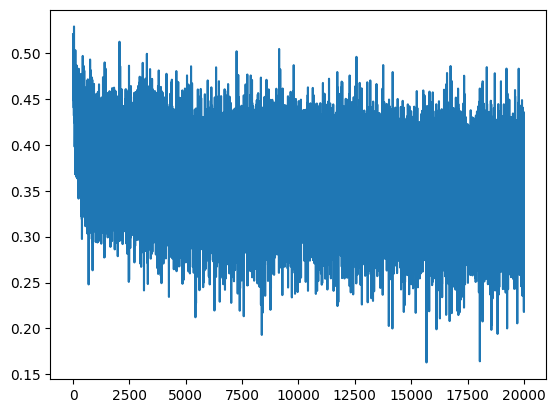

In [53]:
plt.plot(lossi)

In [62]:
# calibrate the batch norm at the end of training - because, well, we'll be sampling the NN, so how tf would be find the mean/std of a batch if it's just one example @.@.

# So instead we calculate the mean/std of the WHOLE training set so we just get 1 single value that doesn't change with each batch (unlike the weird jittery/padding effect it has in training -- see video for info ~50 mins).

with torch.no_grad(): # more efficient with this 
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

## Of course, nobody wants this step after training because we are all lazy so we wanna get a good approximator of this during the training hehe, less steps, yay!


In [67]:
bnmean.mean(), bnmean_running.mean() # Okay, cool, so our means are roughly the same (running mean vs calculated mean at the end). Can see karpathy's vid and he just looks at the tensors and and the elements in both matrices are close to the other one, so that's cool.count
bnstd, bnstd_running # Just like this, see! Wooah, they're basically the same so that's cool. Now we don't have to explicitly find bnmean, bnstd. We just do it as part of our training loop.

(tensor([[1.9947, 1.5289, 1.7462, 1.7705, 1.7327, 1.8243, 1.4281, 1.6252, 1.8654,
          1.4929, 1.8181, 1.6229, 1.4431, 1.7669, 1.2782, 1.7953, 2.1707, 1.3798,
          1.8882, 1.8608, 1.6518, 1.9911, 1.5331, 1.8451, 1.4032, 1.5187, 1.4337,
          1.7142, 1.7630, 1.9526, 1.2265, 1.2166, 2.0538, 1.3957, 1.6470, 1.6108,
          2.0308, 1.6960, 1.7135, 1.6637, 1.6023, 1.5661, 1.7453, 1.7607, 1.4336,
          1.4216, 1.6123, 1.6483, 1.4934, 1.9556, 1.4977, 1.4364, 1.3500, 1.6377,
          1.8781, 1.6775, 1.3910, 1.8383, 2.2218, 1.4759, 1.4662, 1.5381, 1.4530,
          1.5863, 1.9865, 1.8394, 1.4965, 1.7503, 1.6871, 1.8371, 1.6385, 1.5726,
          1.3931, 1.3741, 1.2958, 1.3525, 1.9195, 1.8017, 1.4685, 1.6457, 1.8324,
          1.4441, 1.4554, 1.9550, 1.9715, 1.6940, 1.4366, 1.8579, 2.1979, 1.7838,
          1.4292, 1.5679, 1.7066, 2.0968, 1.9325, 1.5530, 1.7378, 1.4848, 1.4253,
          1.6839, 1.5811, 1.8606, 1.9407, 1.4642, 1.4212, 1.5757, 1.4622, 1.3532,
          1.7090

In [68]:
@torch.no_grad()
def split_loss(split):
	x,y = {
	'train': (Xtr, Ytr),
	'val': (Xdev, Ydev),
	'test': (Xte, Yte),
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
	hpreact = embcat @ W1 + b1
	# hpreact = bngain *(hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias # Batch norming
	# hpreact = bngain * (hpreact-bnmean)/ bnstd
	hpreact = bngain * (hpreact-bnmean_running)/ bnstd_running # Eliminates need for the explicit function above to find bnmean, bnstd. :o. We lazy! Hehe.

	h = torch.tanh(hpreact) # (N, n_hidden)

	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2803308963775635
val 2.297006845474243


In [73]:
b1.grad.mean() # Oh son of a bitch!

tensor(8.9640e-11)

Karpathy cleaning up the code:

In [82]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [83]:
# same optimization as last time
max_steps = 20000#0
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer || Normalises (i.e centres) our batch stuff. Then scales/adds a learnt bias and gain to it as needed. Furthermore, keeps track of our means/std over time so we can use it later in inference and single examples.
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/  20000: 3.3239
  10000/  20000: 2.0322


In [ ]:
# SUMMARY + PYTORCHIFYING ----------- (Part 2 basically: 1:18:00 onwards)

In [6]:
import torch
import torch.nn.functional as F

In [46]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5  #the kaiming initialisation thing from above, as discussed. || Try commmenting out the / fanin bit to see how it affects our network (check the graphs!!). Basically, it fucks the stuff up!
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
	# epsilon to prevent 0 division
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop) || These are the scale/shift bits.
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim) # we're using variance here instead of std, just to keep consistent with pytorch/the papers etc.
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers || For inference/later model evaluation basically.
    if self.training:
      with torch.no_grad(): # || because we don't need gradients for this since we'll never call .backward that needs these.
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
] # || Using batchnorm now, so we don't have to be all finnicky balancing act with our weights initialisation (like see below with torch.no_grad() bit)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident (for softmax output).
  layers[-1].gamma *= 0.1 # || We use batch norm now so we're changing the gamma, not the weight to reduce softmax confidence (for much better initial loss since the prob dist will be ~uniform at initialisation now)
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # We need some gain since our tanh's always keep squishing our damn activations (and squish distribution)! if it's just 1, see what happens to the stats. We counteract the squashing by this 5/3 gain. Too large and everything goes saturated || Even if we're using batchnorm, we don't get a completely free pass to use whatever, since, even though our first few graphs would look fine, the update amount : data ratio will be a bit fucked. but batchnorm still makes everything else more robust

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [47]:
# same optimization as last time
max_steps = 20000#0
batch_size = 32
lossi = []
ud = [] # update: data ratio for every iteration -- we wanna see how much our params will change each learning step

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad(): # Tldr tracking ratio of how strong are our updates to the actual values of the params.
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # Log just so it looks nicer (look at its exponents, yay!)

  if i >= 1000:
	  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  20000: 3.2870


# Using diagnostic tools to see if our NN is in a good state
And what potential problems there could be (around initialisation, learning rates, blah..)

Of course, this is moreso an introduction to it, it's good! But there's still work that needs to be done to understand intuitively these things, and ofc he didn't go over everything in super detail, just gave us the overview of these things and what's good to look for

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

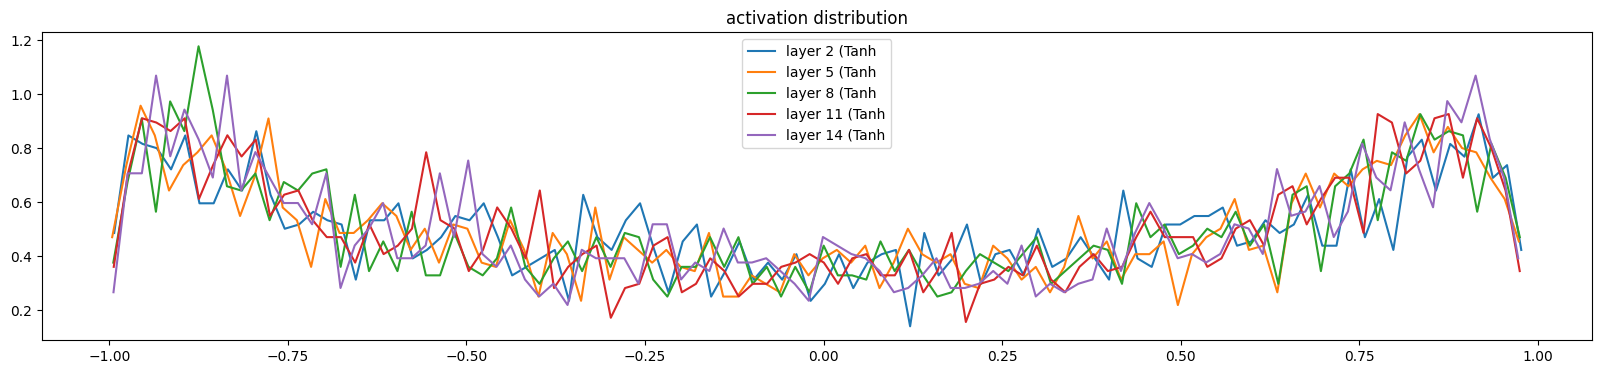

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh): # We're just seeing tanh because the values are finite: [-1, 1] but you could check other stuff. Anyways, pog!
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

## || ~1:47:00 added batchnorming, everything looks very good, 0.65 nice std, nice saturation and our standard deviations are ~equal throughout all our layers (it looks nice and homogenous). 

layer 2 (      Tanh): mean +0.000000, std 3.682949e-03
layer 5 (      Tanh): mean -0.000000, std 3.262605e-03
layer 8 (      Tanh): mean -0.000000, std 2.973726e-03
layer 11 (      Tanh): mean -0.000000, std 2.741107e-03
layer 14 (      Tanh): mean -0.000000, std 2.584292e-03


Text(0.5, 1.0, 'gradient distribution')

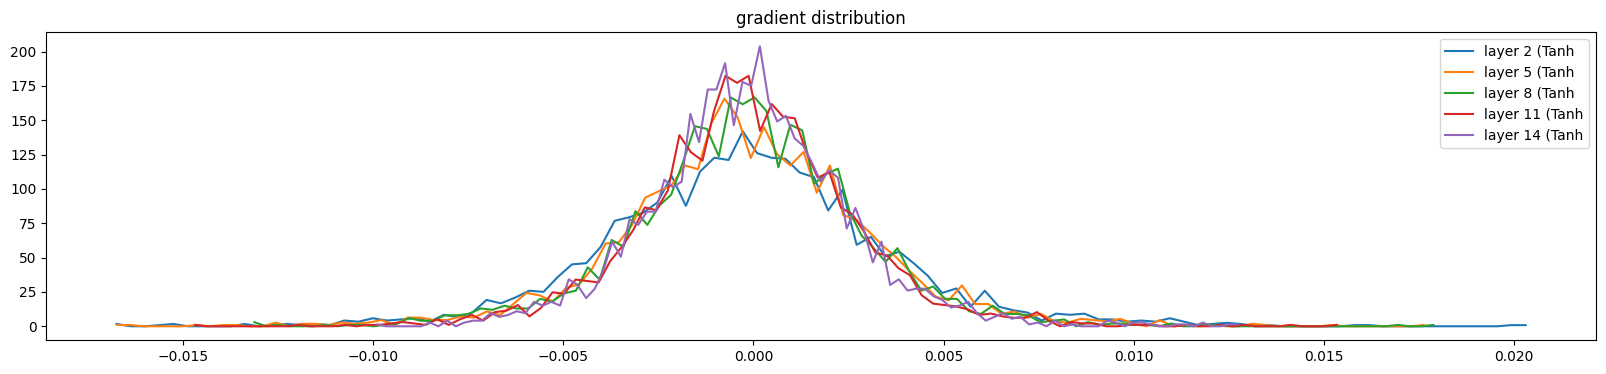

In [52]:
# visualize histograms. For gradients this time
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
# || ~1:47:00 same as above, nice and clean

weight   (27, 10) | mean +0.000000 | std 1.019884e-02 | grad:data ratio 1.018844e-02
weight  (30, 100) | mean +0.000092 | std 8.238419e-03 | grad:data ratio 2.635835e-02
weight (100, 100) | mean +0.000031 | std 7.318100e-03 | grad:data ratio 4.377137e-02
weight (100, 100) | mean -0.000019 | std 6.662019e-03 | grad:data ratio 3.949893e-02
weight (100, 100) | mean -0.000019 | std 5.821510e-03 | grad:data ratio 3.468157e-02
weight (100, 100) | mean +0.000053 | std 5.445291e-03 | grad:data ratio 3.243364e-02
weight  (100, 27) | mean -0.000165 | std 1.046843e-02 | grad:data ratio 6.281257e-02


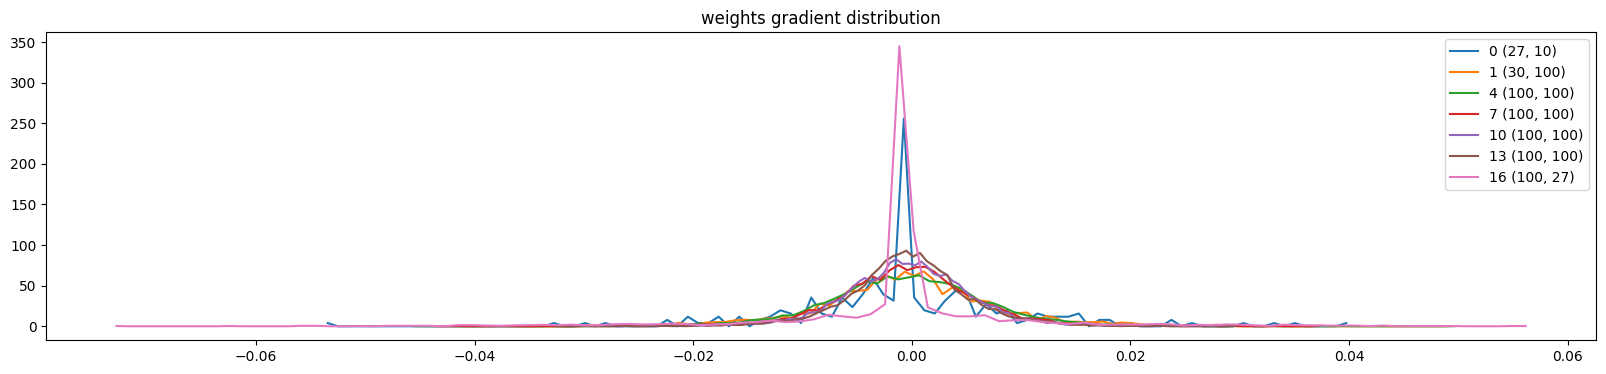

In [53]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # I.e we're only gonna look at weights params for simplicity
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

# This is cool and all, but even better is seeing our update: data ratio because that's what we really want, since it depends on learning rate too (i.e, how much effect does each update have w.r.t the data size per training step)

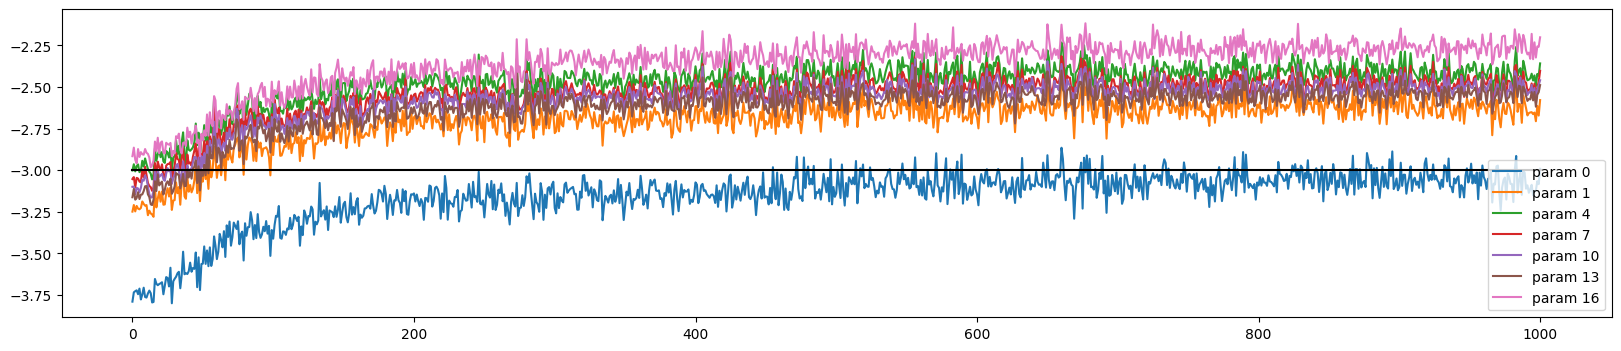

In [54]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2: # weights only params (since they are 2D)
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot ||  I.e, whenever we're updating values for our params, we'd want the update to be ~1000x smaller than the actual value size.
plt.legend(legends);

## You'll notice our param 11 (final layer) has a really high exponent, i.e it's update : data ratio is fuckin BIG. Every step it learns a significant portion of its original data. Why? Well, remember, we artifically reduced the size of the layer with the layers[-1].weight *= 0.1 right? which meant that its values were really small now so our updating will affect it a lot more. But it's nice to still see it converge over time to something.

# If our learning rate is too low, then we'd see stuff below the line 1e-3. So it's not learning fast enough :(

## Tl;dr this guy helps give us information on our learning rate, and our updating and how fast we're learning etc..


### || ~1:47:00 Wow, so we just switched to batchnorm, and now everything is a lot closer together, and around our 1e-3 nice update : data ratio mark!! 

In [ ]:
# Let's have some example of how to tell if it's messed up -- what would the graphs look like?
# Well, try changing the weights initialisation to remove the kaiming / fan_in bit -- see what happens.

## We'll get really high saturation of our activation function (basically everything will be really close to -1, 1)

# Our gradient distribution will look munted and really spread out
# Same with the weight gradient distr

# And your update rate : data value graph will look really weird, (Like all the layers are 'learning' at  different rates -- basically all/most of them should be around the 1e-3 mark, but removing the kaiming bit makes every layer have a different update : data ratio)

In [ ]:
# DONE; BONUS content below, not covered in video

In [25]:
# BatchNorm forward pass as a widget
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np
%matplotlib inline

def normshow(x0): #x1=None):
  
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
#   x[1] = x1 ## second slider if we want!!
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b') # 
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100) # Blue is input (see changing x0 changes a blue one).
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100) # Red is output
  plt.xlim(-6, 6) # could see -30, 30 to be funny
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))
  print(f'{x=}, {y=}')

interact(normshow, x0=(-30,30,0.5)); # x1= (-10, 10, 1)); # Added this x1 bit -- we can have multiple input sliders!!!


### OOOOOH SHIIIT, THIS SHOWS YOU HOW BATCHNORMING WELL, NORMALISES THE VALUES! LOL. IT NORMALISES THE BLUE DISTRIBUTION (our inputs!) INTO A NORMAL/GAUSSIAN DISTRIBUTION (RED!!)
## AHAHAHA SOO COOL!

## See how, despite our input mu and std being *not fucking normal* at all, we normalise it!???!?! AHAHAHHA

interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [26]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [31]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
